# Telco Customer Churn - Data Preprocessing

Prepares the Telco Customer Churn dataset for ML model training:
1. Handle missing values
2. Feature engineering
3. Encode categorical variables
4. Scale numerical features
5. Handle class imbalance (SMOTE-NC)
6. Save processed data

## 1. Setup & Data Loading

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from imblearn.over_sampling import SMOTENC
import warnings
warnings.filterwarnings('ignore')

pd.set_option('display.max_columns', None)

In [2]:
df = pd.read_csv('../data/telco-customer-churn.csv')
print(f'Dataset shape: {df.shape}')
df.head()

Dataset shape: (7043, 21)


,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,Yes,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,No,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,Yes,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,No,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


## 2. Handle Missing Values

In [3]:
print('Missing values per column:')
print(df.isnull().sum())
print(f'\nTotal missing: {df.isnull().sum().sum()}')

Missing values per column:
customerID          0
gender              0
SeniorCitizen       0
Partner             0
Dependents          0
tenure              0
PhoneService        0
MultipleLines       0
InternetService     0
OnlineSecurity      0
OnlineBackup        0
DeviceProtection    0
TechSupport         0
StreamingTV         0
StreamingMovies     0
Contract            0
PaperlessBilling    0
PaymentMethod       0
MonthlyCharges      0
TotalCharges        0
Churn               0
dtype: int64

Total missing: 0


In [4]:
df['TotalCharges'] = pd.to_numeric(df['TotalCharges'], errors='coerce')
print(f'TotalCharges NaN after conversion: {df["TotalCharges"].isnull().sum()}')

TotalCharges NaN after conversion: 11


In [5]:
mask = df['TotalCharges'].isnull()
df.loc[mask, 'TotalCharges'] = df.loc[mask, 'MonthlyCharges']
print(f'Missing after imputation: {df["TotalCharges"].isnull().sum()}')

Missing after imputation: 0


## 3. Feature Engineering

In [6]:
df = df.drop(['customerID', 'SeniorCitizen_label'], axis=1, errors='ignore')

df['AvgMonthlySpend'] = df['TotalCharges'] / (df['tenure'] + 1)

df['TenureGroup'] = pd.cut(df['tenure'],
                           bins=[-1, 12, 24, 48, 72],  # -1 to include tenure=0
                           labels=['0-1yr', '1-2yr', '2-4yr', '4-6yr'])

service_cols = ['OnlineSecurity', 'OnlineBackup', 'DeviceProtection',
                'TechSupport', 'StreamingTV', 'StreamingMovies']
df['TotalServices'] = df[service_cols].apply(lambda x: (x == 'Yes').sum(), axis=1)

print(f'TenureGroup NaN count: {df["TenureGroup"].isna().sum()}')
df[['tenure', 'TenureGroup', 'MonthlyCharges', 'TotalCharges', 'AvgMonthlySpend', 'TotalServices']].head()

TenureGroup NaN count: 0


,tenure,TenureGroup,MonthlyCharges,TotalCharges,AvgMonthlySpend,TotalServices
0,1,0-1yr,29.85,29.85,14.925000,1
1,34,2-4yr,56.95,1889.50,53.985714,2
2,2,0-1yr,53.85,108.15,36.050000,2
3,45,2-4yr,42.30,1840.75,40.016304,3
4,2,0-1yr,70.70,151.65,50.550000,0


## 4. Encode Categorical Variables

In [7]:
cat_cols = df.select_dtypes(include=['object', 'category']).columns.tolist()
print(f'Categorical columns ({len(cat_cols)}): {cat_cols}')

Categorical columns (17): ['gender', 'Partner', 'Dependents', 'PhoneService', 'MultipleLines', 'InternetService', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies', 'Contract', 'PaperlessBilling', 'PaymentMethod', 'Churn', 'TenureGroup']


In [8]:
for col in cat_cols:
    print(f'{col}: {df[col].unique()}')

gender: ['Female' 'Male']
Partner: ['Yes' 'No']
Dependents: ['No' 'Yes']
PhoneService: ['No' 'Yes']
MultipleLines: ['No phone service' 'No' 'Yes']
InternetService: ['DSL' 'Fiber optic' 'No']
OnlineSecurity: ['No' 'Yes' 'No internet service']
OnlineBackup: ['Yes' 'No' 'No internet service']
DeviceProtection: ['No' 'Yes' 'No internet service']
TechSupport: ['No' 'Yes' 'No internet service']
StreamingTV: ['No' 'Yes' 'No internet service']
StreamingMovies: ['No' 'Yes' 'No internet service']
Contract: ['Month-to-month' 'One year' 'Two year']
PaperlessBilling: ['Yes' 'No']
PaymentMethod: ['Electronic check' 'Mailed check' 'Bank transfer (automatic)'
 'Credit card (automatic)']
Churn: ['No' 'Yes']
TenureGroup: ['0-1yr', '2-4yr', '1-2yr', '4-6yr']
Categories (4, object): ['0-1yr' < '1-2yr' < '2-4yr' < '4-6yr']


In [9]:
binary_cols = ['Partner', 'Dependents', 'PhoneService', 'PaperlessBilling', 'Churn']
for col in binary_cols:
    df[col] = df[col].map({'Yes': 1, 'No': 0})

df['gender'] = df['gender'].map({'Male': 1, 'Female': 0})
df[binary_cols + ['gender']].head()

,Partner,Dependents,PhoneService,PaperlessBilling,Churn,gender
0,1,0,0,1,0,0
1,0,0,1,0,0,1
2,0,0,1,1,1,1
3,0,0,0,0,0,1
4,0,0,1,1,1,0


In [10]:
multi_cat_cols = ['MultipleLines', 'InternetService', 'OnlineSecurity', 'OnlineBackup',
                  'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies',
                  'Contract', 'PaymentMethod', 'TenureGroup']

label_encoders = {}
for col in multi_cat_cols:
    le = LabelEncoder()
    df[col] = le.fit_transform(df[col].astype(str))
    label_encoders[col] = le
    print(f'  {col}: {len(le.classes_)} classes -> {list(le.classes_)}')

  MultipleLines: 3 classes -> ['No', 'No phone service', 'Yes']
  InternetService: 3 classes -> ['DSL', 'Fiber optic', 'No']
  OnlineSecurity: 3 classes -> ['No', 'No internet service', 'Yes']
  OnlineBackup: 3 classes -> ['No', 'No internet service', 'Yes']
  DeviceProtection: 3 classes -> ['No', 'No internet service', 'Yes']
  TechSupport: 3 classes -> ['No', 'No internet service', 'Yes']
  StreamingTV: 3 classes -> ['No', 'No internet service', 'Yes']
  StreamingMovies: 3 classes -> ['No', 'No internet service', 'Yes']
  Contract: 3 classes -> ['Month-to-month', 'One year', 'Two year']
  PaymentMethod: 4 classes -> ['Bank transfer (automatic)', 'Credit card (automatic)', 'Electronic check', 'Mailed check']
  TenureGroup: 4 classes -> ['0-1yr', '1-2yr', '2-4yr', '4-6yr']


In [11]:
df_encoded = df
df_encoded.head()

,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn,AvgMonthlySpend,TenureGroup,TotalServices
0,0,0,1,0,1,0,1,0,0,2,0,0,0,0,0,1,2,29.85,29.85,0,14.925000,0,1
1,1,0,0,0,34,1,0,0,2,0,2,0,0,0,1,0,3,56.95,1889.50,0,53.985714,2,2
2,1,0,0,0,2,1,0,0,2,2,0,0,0,0,0,1,3,53.85,108.15,1,36.050000,0,2
3,1,0,0,0,45,0,1,0,2,0,2,2,0,0,1,0,0,42.30,1840.75,0,40.016304,2,3
4,0,0,0,0,2,1,0,1,0,0,0,0,0,0,0,1,2,70.70,151.65,1,50.550000,0,0


## 5. Scale Numerical Features

In [12]:
numerical_cols = ['tenure', 'MonthlyCharges', 'TotalCharges', 'AvgMonthlySpend', 'TotalServices']
df_encoded[numerical_cols].describe().round(2)

,tenure,MonthlyCharges,TotalCharges,AvgMonthlySpend,TotalServices
count,7043.00,7043.00,7043.00,7043.00,7043.00
mean,32.37,64.76,2279.80,59.06,2.04
std,24.56,30.09,2266.73,30.51,1.85
min,0.00,18.25,18.80,9.18,0.00
25%,9.00,35.50,398.55,26.18,0.00
50%,29.00,70.35,1394.55,61.02,2.00
75%,55.00,89.85,3786.60,84.83,3.00
max,72.00,118.75,8684.80,118.97,6.00


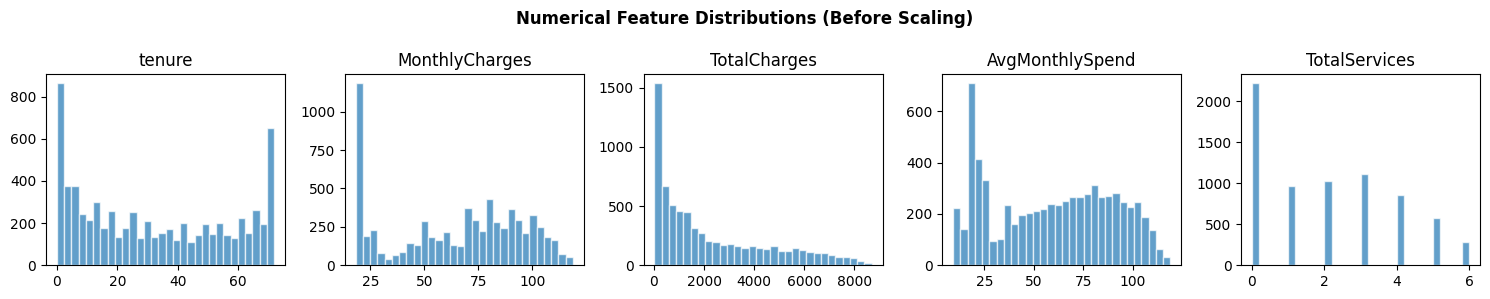

In [13]:
fig, axes = plt.subplots(1, len(numerical_cols), figsize=(15, 3))
for i, col in enumerate(numerical_cols):
    axes[i].hist(df_encoded[col], bins=30, edgecolor='white', alpha=0.7)
    axes[i].set_title(col)
plt.suptitle('Numerical Feature Distributions (Before Scaling)', fontweight='bold')
plt.tight_layout()
plt.show()

In [14]:
scaler = StandardScaler()
df_encoded[numerical_cols] = scaler.fit_transform(df_encoded[numerical_cols])
df_encoded[numerical_cols].describe().round(2)

,tenure,MonthlyCharges,TotalCharges,AvgMonthlySpend,TotalServices
count,7043.00,7043.00,7043.00,7043.00,7043.00
mean,-0.00,-0.00,-0.00,0.00,0.00
std,1.00,1.00,1.00,1.00,1.00
min,-1.32,-1.55,-1.00,-1.63,-1.10
25%,-0.95,-0.97,-0.83,-1.08,-1.10
50%,-0.14,0.19,-0.39,0.06,-0.02
75%,0.92,0.83,0.66,0.84,0.52
max,1.61,1.79,2.83,1.96,2.14


## 6. Handle Class Imbalance (SMOTE-NC)

Churn rate: 26.54%
Churn
0    5174
1    1869
Name: count, dtype: int64


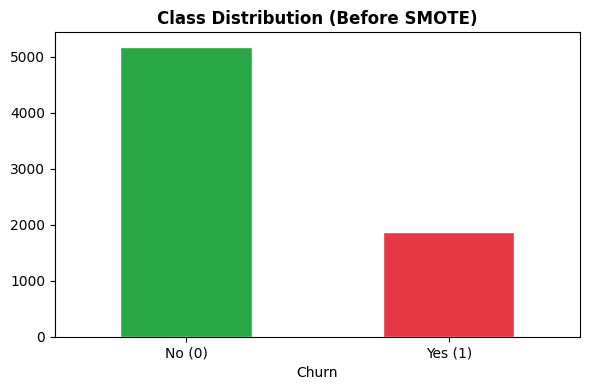

In [15]:
print(f'Churn rate: {df_encoded["Churn"].mean()*100:.2f}%')
print(df_encoded['Churn'].value_counts())

plt.figure(figsize=(6, 4))
df_encoded['Churn'].value_counts().plot(kind='bar', color=['#28A745', '#E63946'], edgecolor='white')
plt.title('Class Distribution (Before SMOTE)', fontweight='bold')
plt.xticks([0, 1], ['No (0)', 'Yes (1)'], rotation=0)
plt.tight_layout()
plt.show()

In [16]:
X = df_encoded.drop('Churn', axis=1)
y = df_encoded['Churn']
print(f'Features: {X.shape}, Target: {y.shape}')

Features: (7043, 22), Target: (7043,)


In [17]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)
print(f'Train: {X_train.shape[0]}, Test: {X_test.shape[0]}')
print(y_train.value_counts())

Train: 5634, Test: 1409
Churn
0    4139
1    1495
Name: count, dtype: int64


In [18]:
categorical_indices = [list(X_train.columns).index(col) for col in multi_cat_cols]

smote_nc = SMOTENC(categorical_features=categorical_indices, random_state=42)
X_train_resampled, y_train_resampled = smote_nc.fit_resample(X_train, y_train)

print(f'After SMOTE-NC: {X_train_resampled.shape[0]} samples')
print(pd.Series(y_train_resampled).value_counts())

After SMOTE-NC: 8278 samples
Churn
0    4139
1    4139
Name: count, dtype: int64


In [19]:
def expand_one_hot(data, col, le):
    """Convert a label-encoded column back to one-hot columns."""
    int_vals = data[col].round().astype(int).clip(0, len(le.classes_) - 1)
    for cat_idx, cat in enumerate(le.classes_):
        clean_name = f'{col}_{cat}'.replace(' ', '_').replace('(', '').replace(')', '').replace('-', '_')
        data[clean_name] = (int_vals == cat_idx).astype(int)
    return data.drop(columns=[col])

def expand_all_one_hot(data, cols, encoders):
    for col in cols:
        data = expand_one_hot(data, col, encoders[col])
    return data

def clean_columns(df):
    df.columns = (df.columns.str.replace(' ', '_')
                  .str.replace('(', '').str.replace(')', '').str.replace('-', '_'))
    return df

X_train_oh = clean_columns(expand_all_one_hot(
    pd.DataFrame(X_train_resampled, columns=X_train.columns), multi_cat_cols, label_encoders))
X_train_orig_oh = clean_columns(expand_all_one_hot(
    pd.DataFrame(X_train.values, columns=X_train.columns), multi_cat_cols, label_encoders))
X_test_oh = clean_columns(expand_all_one_hot(
    pd.DataFrame(X_test.values, columns=X_test.columns), multi_cat_cols, label_encoders))

print(f'SMOTE train: {X_train_oh.shape}, Original train: {X_train_orig_oh.shape}, Test: {X_test_oh.shape}')

SMOTE train: (8278, 46), Original train: (5634, 46), Test: (1409, 46)


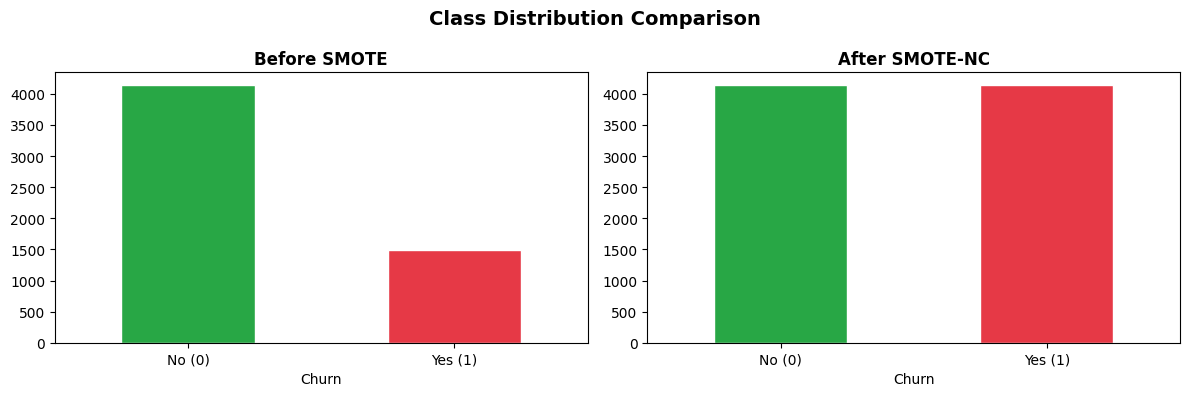

In [20]:
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

y_train.value_counts().plot(kind='bar', ax=axes[0], color=['#28A745', '#E63946'], edgecolor='white')
axes[0].set_title('Before SMOTE', fontweight='bold')
axes[0].set_xticklabels(['No (0)', 'Yes (1)'], rotation=0)

pd.Series(y_train_resampled).value_counts().plot(kind='bar', ax=axes[1], color=['#28A745', '#E63946'], edgecolor='white')
axes[1].set_title('After SMOTE-NC', fontweight='bold')
axes[1].set_xticklabels(['No (0)', 'Yes (1)'], rotation=0)

plt.suptitle('Class Distribution Comparison', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

## 7. Save Processed Data

In [21]:
import os
os.makedirs('../data/processed', exist_ok=True)

train_df = X_train_oh.copy()
train_df['Churn'] = y_train_resampled.values if hasattr(y_train_resampled, 'values') else y_train_resampled
train_df.to_csv('../data/processed/train_smote.csv', index=False)

train_orig_df = X_train_orig_oh.copy()
train_orig_df['Churn'] = y_train.values
train_orig_df.to_csv('../data/processed/train_original.csv', index=False)

test_df = X_test_oh.copy()
test_df['Churn'] = y_test.values
test_df.to_csv('../data/processed/test.csv', index=False)

print(f'train_smote.csv: {train_df.shape}')
print(f'train_original.csv: {train_orig_df.shape}')
print(f'test.csv: {test_df.shape}')

train_smote.csv: (8278, 47)
train_original.csv: (5634, 47)
test.csv: (1409, 47)


In [22]:
import pickle

feature_names = X_train_oh.columns.tolist()
with open('../data/processed/feature_names.pkl', 'wb') as f:
    pickle.dump(feature_names, f)

with open('../data/processed/scaler.pkl', 'wb') as f:
    pickle.dump(scaler, f)

print(f'{len(feature_names)} feature names and scaler saved')

46 feature names and scaler saved


## Summary

In [23]:
print('=' * 50)
print('       PREPROCESSING SUMMARY')
print('=' * 50)
print(f'Original: 7043 rows -> {len(X_train_oh.columns)} features')
print(f'TenureGroup bins: [-1, 12, 24, 48, 72]')
print(f'Encoding: Binary + Label->SMOTE-NC->One-Hot')
print(f'Scaling: StandardScaler')
print(f'Class balance: {y_train.value_counts()[0]}/{y_train.value_counts()[1]} -> {pd.Series(y_train_resampled).value_counts()[0]}/{pd.Series(y_train_resampled).value_counts()[1]}')
print(f'Train (SMOTE-NC): {train_df.shape[0]}, Test: {test_df.shape[0]}')
print('=' * 50)

       PREPROCESSING SUMMARY
Original: 7043 rows -> 46 features
TenureGroup bins: [-1, 12, 24, 48, 72]
Encoding: Binary + Label->SMOTE-NC->One-Hot
Scaling: StandardScaler
Class balance: 4139/1495 -> 4139/4139
Train (SMOTE-NC): 8278, Test: 1409
